In [83]:
%matplotlib inline
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import seaborn as sns

In [84]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.utils import * 

In [85]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob


def make_dir(path):
    if os.path.exists(path) is False:
        os.makedirs(path)
        
        
def prepare_predictor(data_sets, data_path):
    """
    Args:
        data_sets list(str): names of datasets
    """
        
    # Create training and testing arrays
    if isinstance(data_sets, str):
        data_sets = [data_sets]
        
    X_all      = []
    length_all = []
    
    for file in data_sets:
        #data = xr.open_dataset(os.path.join(data_path, f"{file}.nc"))
        data= pd.read_csv(f'{file}.csv')
        X_all.append(data)
        #length_all.append(Series(X_all).size)
    
    #X = xr.concat(X_all,dim='time')
    X= pd.concat(X_all, sort=False)
    #length_all = np.array(length_all)
    # X = xr.concat([xr.open_dataset(data_path + f"inputs_{file}.nc") for file in data_sets], dim='time')
    
    #if time_reindex:
        #X = X.assign_coords(time=np.arange(len(X.time)))

    return X
#, length_all

def prepare_predictand(data_sets,data_path):
    if isinstance(data_sets, str):
        data_sets = [data_sets]
        
    Y_all = []
    length_all = []
    
    for file in data_sets:
        #data = xr.open_dataset(os.path.join(data_path, f"outputs_{file}.nc"))
        data= pd.read_csv(f'{file}.csv')
        Y_all.append(data)
        #length_all.append(len(data.time))
    
    length_all = np.array(length_all)
    #Y = xr.concat(Y_all,dim='time').mean('member')
    Y= pd.concat(Y_all, sort=False)
    # Y = xr.concat([xr.open_dataset(data_path + f"outputs_{file}.nc") for file in data_sets], dim='time').mean("member")
    #Y = Y.rename({'lon':'longitude','lat': 'latitude'}).transpose('time','latitude', 'longitude').drop(['quantile'])
    #if time_reindex:
        #Y = Y.assign_coords(time=np.arange(len(Y.time)))
    
    return Y


def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.latitude))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['latitude', 'longitude'])).data.mean()

def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean squared error')
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()
    
    
    
    
# Utilities for normalizing the input data
def normalize(data, var, meanstd_dict):
    mean = meanstd_dict[var][0]
    std = meanstd_dict[var][1]
    return (data - mean)/std

def mean_std_plot(data,color,label,ax):
    
    mean = data.mean(['latitude','longitude'])
    std  = data.std(['latitude','longitude'])
    yr   = data.time.values

    ax.plot(yr,mean,color=color,label=label,linewidth=4)
    ax.fill_between(yr,mean+std,mean-std,facecolor=color,alpha=0.4)
    
    return yr, mean

In [87]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

In [88]:
cwd = os.getcwd()

train_path = os.path.join(cwd,'Data','train_val')
test_path  = os.path.join(cwd,'Data','test')

make_dir(train_path)
make_dir(test_path)

In [89]:
cwd

'/Users/huangyining'

In [90]:
# Training set
train_files = ["newtrain_x"]
train_path = '/Users/huangyining/Desktop/'
X_train_xr  = prepare_predictor(train_files,train_path)
train_files = ["newtrain_y"]
y_train_xr  = prepare_predictand(train_files,train_path)

# Test set
test_path = '/Users/huangyining/Desktop/'
train_files=['newtest_x']
X_test_xr = prepare_predictor(train_files, data_path=test_path)
train_files=['newtest_y']
y_test_xr = prepare_predictand(train_files,data_path=test_path)

In [91]:
X_test_xr.head

<bound method NDFrame.head of               DATE  HourlyDewPointTemperature_x  HourlyDryBulbTemperature_x  \
0    2019-03-12T03                           17                          36   
1    2019-03-12T09                           18                          37   
2    2019-03-12T15                           17                          43   
3    2019-03-12T18                           16                          39   
4    2019-03-13T03                           17                          34   
..             ...                          ...                         ...   
584  2019-08-21T18                           73                          76   
585  2019-08-22T03                           70                          76   
586  2019-08-22T09                           68                          83   
587  2019-08-22T15                           65                          88   
588  2019-08-22T18                           69                          80   

     HourlyWindpeed_x

In [92]:
A=X_train_xr.drop(columns=['DATE'])
C=y_train_xr.drop(columns=['DATE'])
#A

In [93]:
result=pd.concat([A,C],axis=1)

In [94]:
B=result.corr()

<AxesSubplot:>

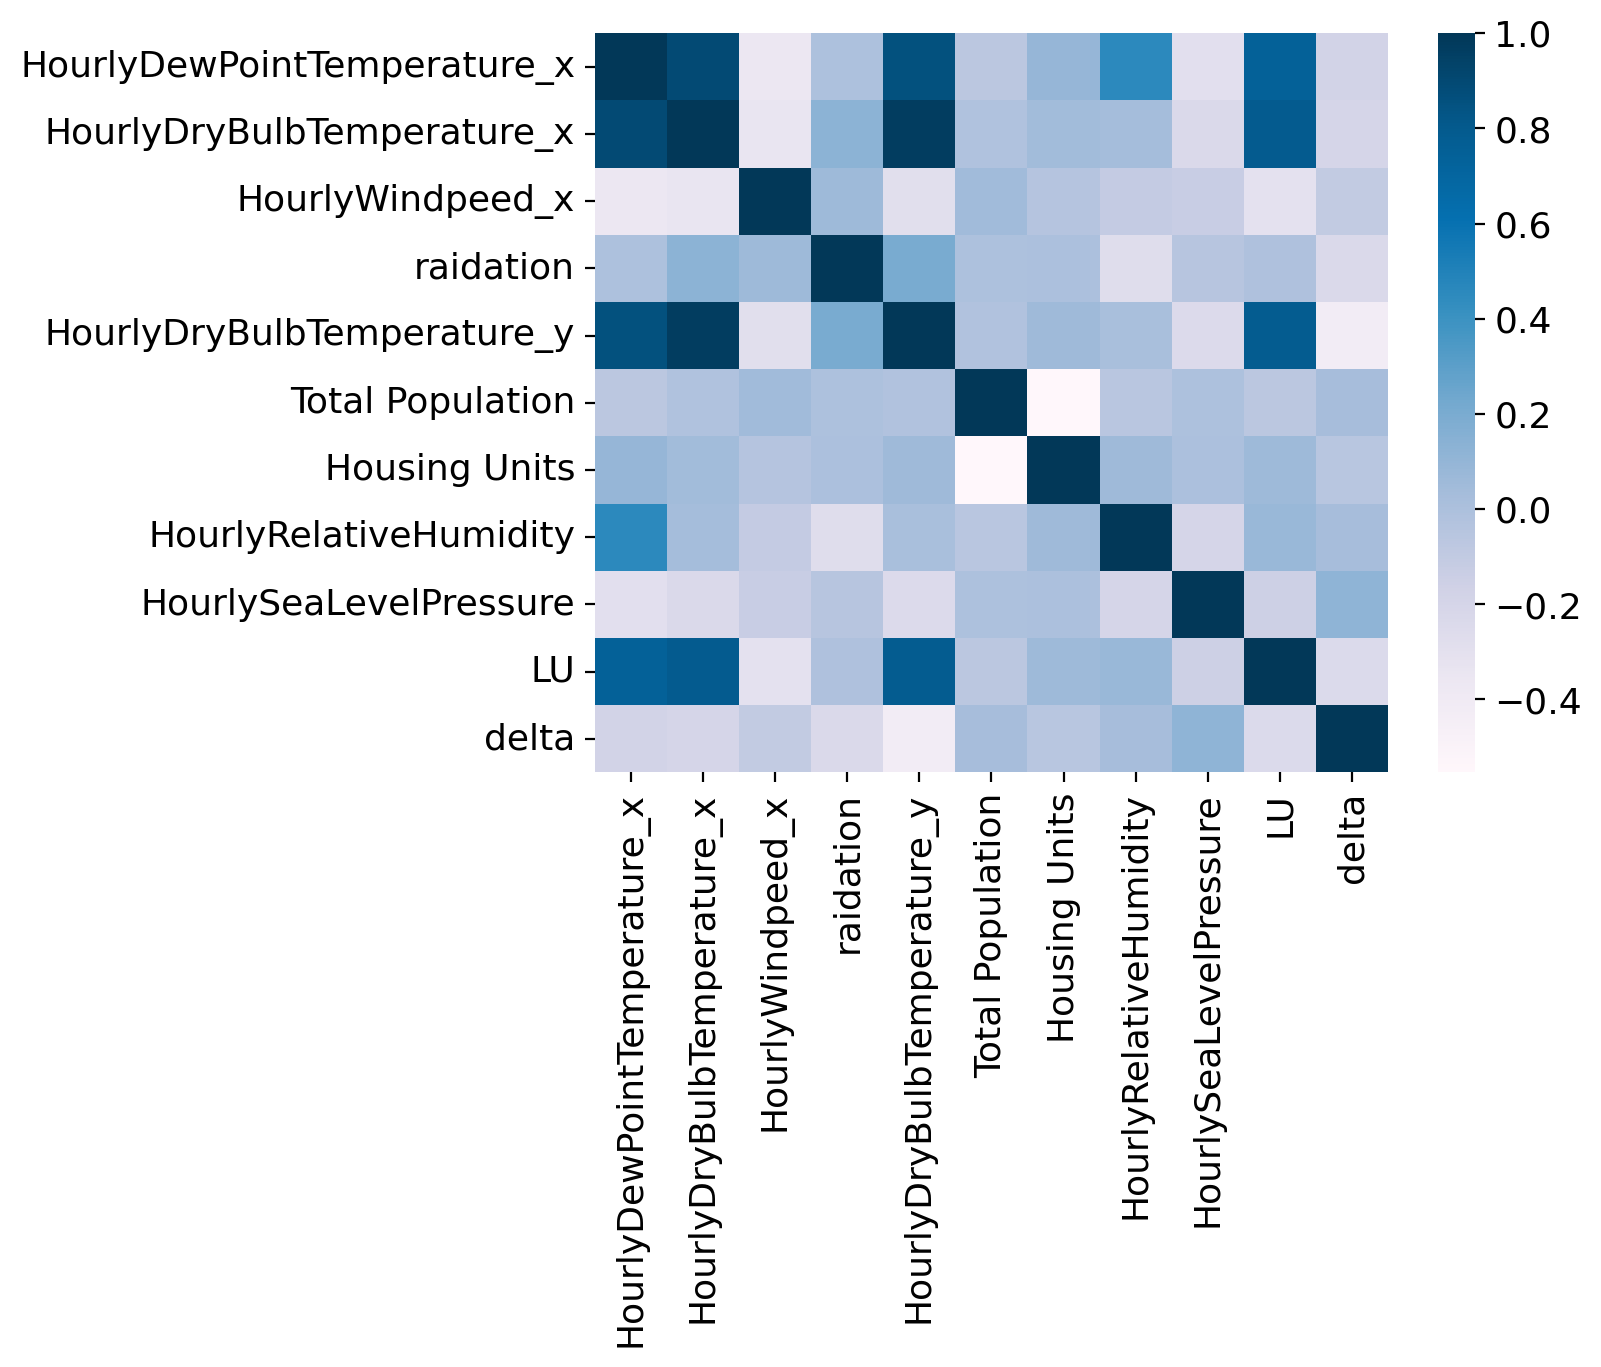

In [95]:
sns.heatmap(B,cmap='PuBu')

In [61]:
X_train_xr=X_train_xr.drop(columns=['HourlyDewPointTemperature_x'])
X_test_xr=X_test_xr.drop(columns=['HourlyDewPointTemperature_x'])

In [96]:
X_train_xr.describe()

,HourlyDewPointTemperature_x,HourlyDryBulbTemperature_x,HourlyWindpeed_x,raidation,HourlyDryBulbTemperature_y,Total Population,Housing Units,HourlyRelativeHumidity,HourlySeaLevelPressure,LU
count,6348.000000,6348.000000,6348.000000,6348.000000,6348.000000,6.348000e+03,6.348000e+03,6348.000000,6348.000000,6348.000000
mean,41.375551,56.726686,5.303245,11.163989,52.624606,8.442160e+06,3.437337e+06,59.039540,3002.937933,3814.282924
std,20.030270,18.228496,3.649986,5.806885,20.012886,2.441520e+04,2.216915e+04,18.478255,23.046188,1751.932533
min,-19.000000,2.000000,0.000000,3.000000,-11.000000,8.396614e+06,3.407932e+06,11.000000,2903.000000,1648.000000
25%,27.000000,42.000000,3.000000,3.000000,37.000000,8.433867e+06,3.422225e+06,45.000000,2988.750000,2017.000000
50%,44.000000,58.000000,5.000000,9.000000,54.000000,8.437695e+06,3.436084e+06,57.000000,3002.000000,3823.000000
75%,58.000000,72.000000,7.000000,18.000000,70.000000,8.463157e+06,3.455117e+06,74.000000,3017.000000,5472.000000
max,77.000000,94.000000,25.000000,18.000000,95.000000,8.468954e+06,3.472354e+06,100.000000,3084.000000,6591.000000


In [97]:
X_test_xr

,DATE,HourlyDewPointTemperature_x,HourlyDryBulbTemperature_x,HourlyWindpeed_x,raidation,HourlyDryBulbTemperature_y,Total Population,Housing Units,HourlyRelativeHumidity,HourlySeaLevelPressure,LU
0,2019-03-12T03,17,36,13,3,32,8342925,3494228,46,3011,2247
1,2019-03-12T09,18,37,9,9,35,8342925,3494228,50,3021,2247
2,2019-03-12T15,17,43,10,15,39,8342925,3494228,40,3020,2247
3,2019-03-12T18,16,39,9,18,34,8342925,3494228,41,3027,2247
4,2019-03-13T03,17,34,3,3,22,8342925,3494228,52,3034,2247
...,...,...,...,...,...,...,...,...,...,...,...
584,2019-08-21T18,73,76,0,18,74,8342925,3494228,71,2985,5410
585,2019-08-22T03,70,76,7,3,67,8342925,3494228,74,2981,5410
586,2019-08-22T09,68,83,5,9,81,8342925,3494228,57,2987,5410
587,2019-08-22T15,65,88,3,15,78,8342925,3494228,37,2982,5410


In [98]:
X_train_df = pd.DataFrame({"housingunits": X_train_xr["Housing Units"],
                           "population": X_train_xr["Total Population"],
                           "radiation" :X_train_xr["raidation"],
                           "windpeed": X_train_xr["HourlyWindpeed_x"],
                           "humidity" :X_train_xr["HourlyRelativeHumidity"],
                           "pressure": X_train_xr["HourlySeaLevelPressure"],
                           "LU": X_train_xr["LU"],
                           "Dew": X_train_xr["HourlyDewPointTemperature_x"],
                           #"LST": X_train_xr["HourlyDryBulbTemperature_y"]
                          })
X_test_df  = pd.DataFrame({"housingunits": X_test_xr["Housing Units"],
                           "population": X_test_xr["Total Population"],
                           "radiation" :X_test_xr["raidation"],
                           "windpeed": X_test_xr["HourlyWindpeed_x"],
                           "humidity" :X_test_xr["HourlyRelativeHumidity"],
                           "pressure": X_test_xr["HourlySeaLevelPressure"],
                           "LU": X_test_xr["LU"],
                           "Dew": X_test_xr["HourlyDewPointTemperature_x"],
                           #"LST": X_test_xr["HourlyDryBulbTemperature_y"]
                          })
y_train_df =pd.DataFrame({
                          "LST": y_train_xr["delta"]
                          })
y_test_df =pd.DataFrame({
                          "LST": y_test_xr["delta"]
                          })

In [99]:
X_test_df.head()

,housingunits,population,radiation,windpeed,humidity,pressure,LU,Dew
0,3494228,8342925,3,13,46,3011,2247,17
1,3494228,8342925,9,9,50,3021,2247,18
2,3494228,8342925,15,10,40,3020,2247,17
3,3494228,8342925,18,9,41,3027,2247,16
4,3494228,8342925,3,3,52,3034,2247,17


In [100]:
y_train_df.head()

,LST
0,7
1,4
2,2
3,5
4,10


In [101]:
#Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std
X_train_df.dropna()
y_train_df.dropna()
X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()

print(X_train.shape,X_test.shape)


(6348, 8) (589, 8)


In [102]:
X_train

array([[-1.32640062, -0.33966422, -1.40591534, ...,  1.39120914,
        -1.19255901, -1.7661046 ],
       [-1.32640062, -0.33966422, -0.37265912, ...,  1.65155589,
        -1.19255901, -1.46655795],
       [-1.32640062, -0.33966422,  0.6605971 , ...,  1.34781802,
        -1.19255901, -1.26686019],
       ...,
       [ 1.57952896, -1.86547601, -1.40591534, ..., -2.42720984,
         0.21274625,  0.97973961],
       [ 1.57952896, -1.86547601, -0.37265912, ..., -1.77634297,
         0.21274625,  0.08109969],
       [ 1.57952896, -1.86547601,  0.6605971 , ..., -1.4726051 ,
         0.21274625, -0.06867363]])

In [103]:
n_estimators      = 150    # Number of trees in random forest
min_samples_split = 5     # Minimum number of samples required to split a node
min_samples_leaf  = 12      # Minimum number of samples required at each leaf node
max_features      = 'auto' # Number of features to consider at every split
max_depth         = 40     # Maximum number of levels in tree
bootstrap         = True   # Method of selecting samples for training each tree

reg0 = RandomForestRegressor(n_estimators=n_estimators,
                             min_samples_split=min_samples_split,
                             min_samples_leaf=min_samples_leaf,
                             max_features=max_features,
                             max_depth=max_depth,
                             bootstrap=bootstrap)

rf_tas = reg0.fit(X_train,y_train)

/var/folders/bn/8gtlqh9x253gthjyh5f5qslw0000gn/T/ipykernel_17412/2694878734.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_tas = reg0.fit(X_train,y_train)


In [104]:
rf_tas = reg0.fit(X_train,y_train)

/var/folders/bn/8gtlqh9x253gthjyh5f5qslw0000gn/T/ipykernel_17412/2325638627.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_tas = reg0.fit(X_train,y_train)


In [105]:
importance=reg0.feature_importances_
indice=np.argsort(importance)[::1]

In [106]:
feat_labels=X_train_df.columns[0:]

In [107]:
for i in range(X_train.shape[1]):
    print(feat_labels[i],importance[indice[i]])

housingunits 0.024668482892296933
population 0.03329948215791719
radiation 0.06460420035213957
windpeed 0.07156251370359301
humidity 0.0887905881211629
pressure 0.12888457052589095
LU 0.22804400316536577
Dew 0.36014615908163367


In [108]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 5)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5,55, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15, 25]

# Minimum number of samples required at each leaf node
min_samples_leaf = [4, 8, 12,16]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [109]:
print(random_grid)

{'n_estimators': [100, 150, 200, 250, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, None], 'min_samples_split': [5, 10, 15, 25], 'min_samples_leaf': [4, 8, 12, 16], 'bootstrap': [True, False]}


In [110]:
reg0 = RandomForestRegressor(random_state=0)
# perform cross validation
rf_random0 = RandomizedSearchCV(estimator = reg0, param_distributions = random_grid, 
                                n_iter = 5, cv = 3, verbose=2, n_jobs = -1)

rf_tas = rf_random0.fit(X_train,y_train)

print("The best hyperparameters: \n",rf_tas.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/Users/huangyining/opt/anaconda3/envs/keras/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/huangyining/opt/anaconda3/envs/keras/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/huangyining/opt/anaconda3/envs/keras/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/huangyining/opt/anaconda3/envs/ke

The best hyperparameters: 
 {'n_estimators': 200, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 55, 'bootstrap': True}


In [111]:
y_test_pre = rf_tas.predict(X_test)

In [112]:
Ypre=pd.DataFrame(y_test_pre)
Ypre

,0
0,6.512167
1,2.667383
2,2.826961
3,4.697905
4,10.023912
...,...
584,1.790908
585,5.341314
586,1.147722
587,0.528763


In [113]:
Ypre.to_csv('Dewprediction.csv',index=False)

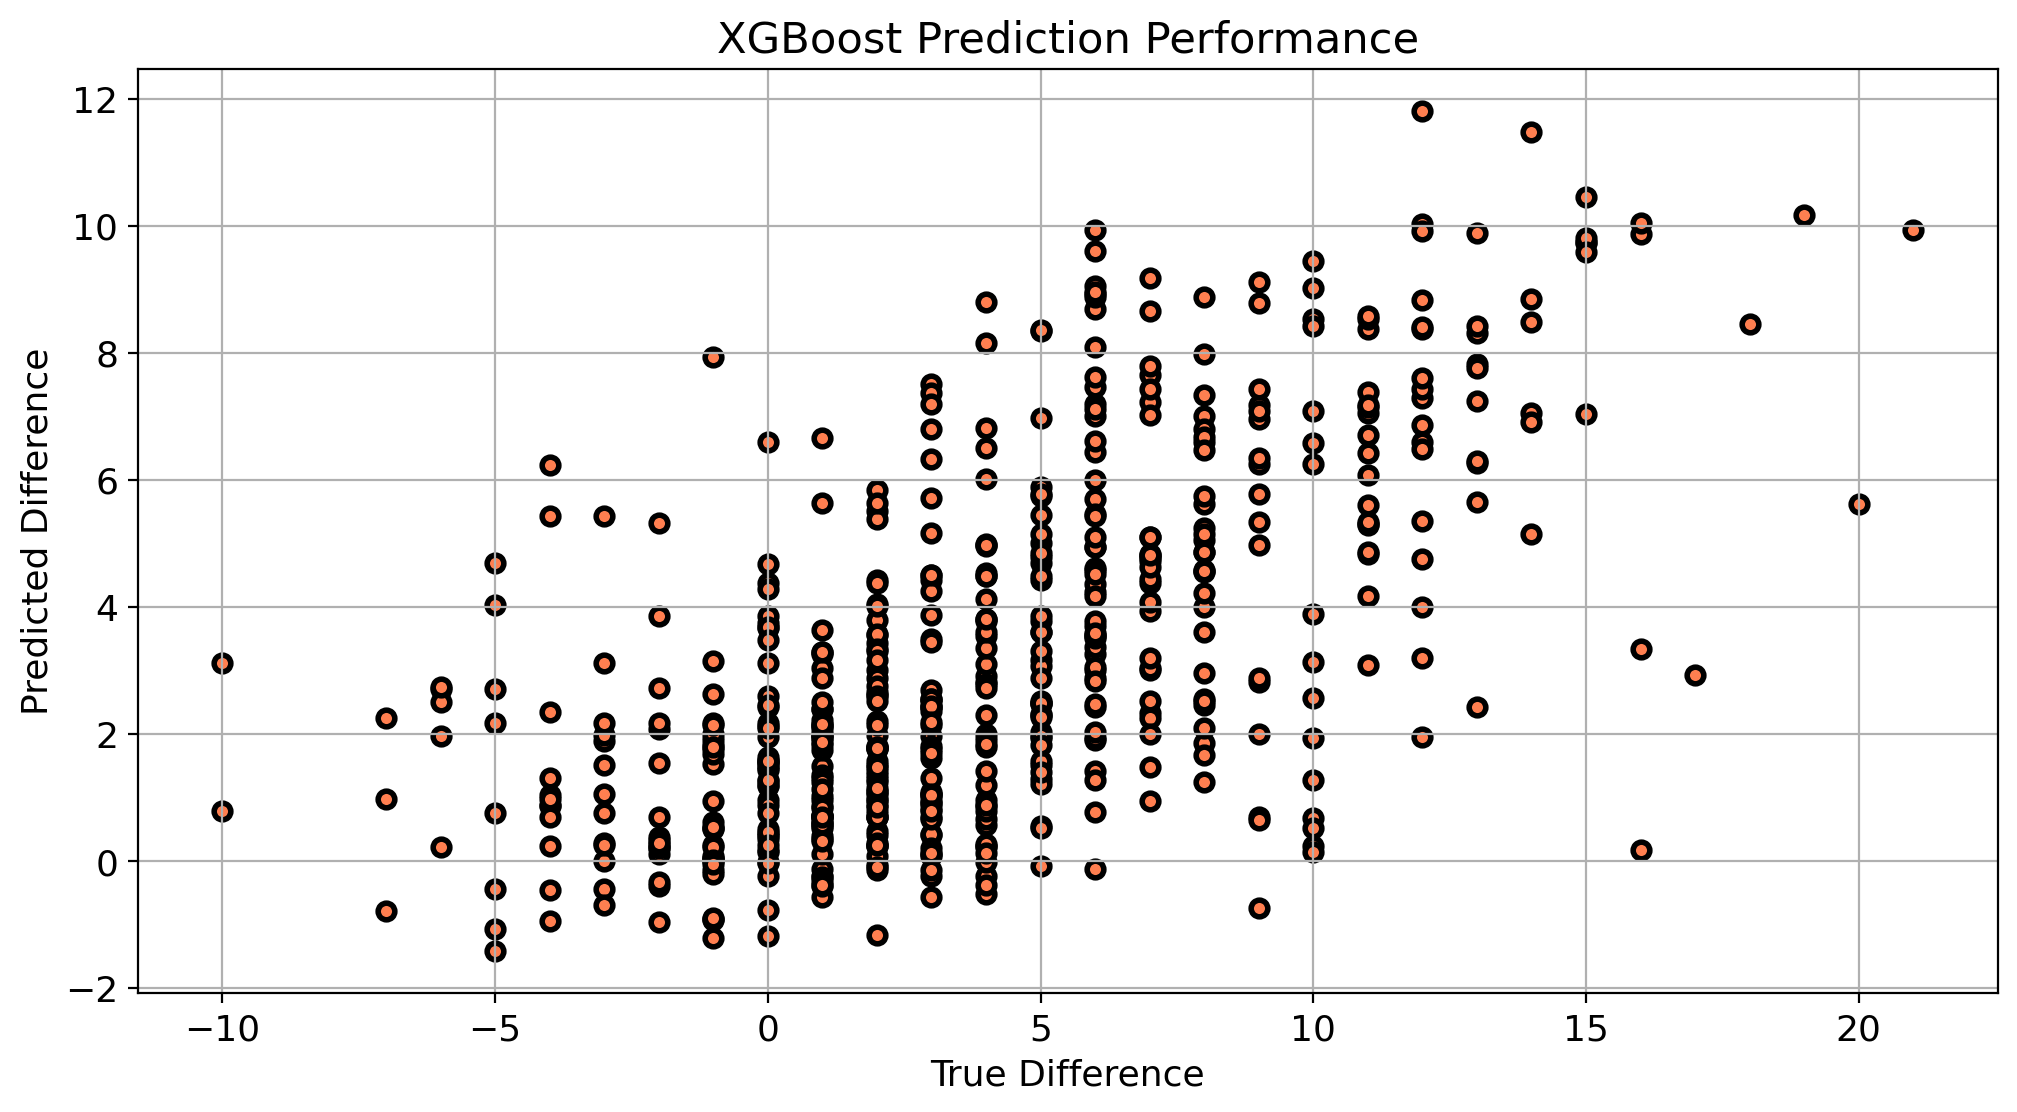

In [115]:
fig = plt.figure(figsize=(12, 6))
plt.scatter(y_test_xr["delta"], y_test_pre,color='coral', linewidths=2, edgecolors='k')
plt.xlabel('True Difference') 
plt.ylabel('Predicted Difference') 
plt.title('XGBoost Prediction Performance') 
plt.grid()